In [1]:
import os
import easydict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST


from utils import anomaly_score
from model_mnist import Generator, Discriminator, init_weights
from train import train

In [2]:
# Parameter
args = easydict.EasyDict({
    "data_dir"  : './data',
    "log_dir"   : './runs',
    "ckpt_dir"  : './ckpt',
    "device"    : torch.device('cuda:0'),
    "batch_size": 256,
    "lr"        : 2e-4,    
    "train_epoch" : 20,
    "latent_iter" : 500
})

In [3]:
# Train dataloader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])
train_dataset = MNIST(args.data_dir, transform=transform, train=True, download=True)
idx = train_dataset.targets==1
train_dataset.data = train_dataset.data[idx]
train_dataset.targets = train_dataset.targets[idx]
train_loader  = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2)

In [4]:
# Train
train(train_loader, args)

Epoch 0 Train Start
Epoch 0 | G_loss 3.8490 | D_loss 0.2356 | Time 5.62
----------------------------------------------------------------------------------------------------
Epoch 1 Train Start
Epoch 1 | G_loss 4.4676 | D_loss 0.0717 | Time 4.73
----------------------------------------------------------------------------------------------------
Epoch 2 Train Start
Epoch 2 | G_loss 4.5280 | D_loss 0.2726 | Time 4.67
----------------------------------------------------------------------------------------------------
Epoch 3 Train Start
Epoch 3 | G_loss 4.7138 | D_loss 0.1320 | Time 4.64
----------------------------------------------------------------------------------------------------
Epoch 4 Train Start
Epoch 4 | G_loss 3.1300 | D_loss 0.5954 | Time 4.65
----------------------------------------------------------------------------------------------------
Epoch 5 Train Start
Epoch 5 | G_loss 2.9429 | D_loss 0.4045 | Time 4.69
---------------------------------------------------------------

In [14]:
# Load Best Generator and Discriminator
last_epoch = 'epoch19.pth'
ckpt_path = args.ckpt_dir + '/' + last_epoch 
ckpt = torch.load(ckpt_path)

netG = Generator(d=64).to(args.device)
netD = Discriminator(d=64).to(args.device)
netG.load_state_dict(ckpt['netG'])
netD.load_state_dict(ckpt['netD'])

<All keys matched successfully>

In [15]:
# Load test data and noise 
test_num = [0, 1, 2]
x_test = []
z_test = []
for n in test_num:
    test_dataset = MNIST(args.data_dir, transform=transform, train=False, download=True)    
    idx = test_dataset.targets==n
    test_dataset.data = test_dataset.data[idx]
    test_dataset.targets = test_dataset.targets[idx]
    x_n = test_dataset[0][0].reshape((1,1,28,28)).to(args.device)
    z_n = torch.randn(1, 100, 1, 1, device=args.device)
    z_n.requires_grad=True
    
    x_test.append(x_n)
    z_test.append(z_n)

In [16]:
# Generate similar data by trained generator
result = []
for i in range(3):    
    optimizer = optim.Adam([z_test[i]], lr=args.lr, betas=(0.5, 0.999))
    
    for step in range(args.latent_iter):        
        optimizer.zero_grad()
        loss = anomaly_score(x_test[i], z_test[i], netD, netG, lam=0.1)
        loss.backward()
        optimizer.step()
        
        if(step%100==0):
            print("Iteration {0: d} | Loss {1:.4f}".format(step, loss.item()))
    
    img = netG(z_test[i])
    score = loss.item()            
    result.append([img, loss])

Iteration  0 | Loss 0.4786
Iteration  100 | Loss 0.4714
Iteration  200 | Loss 0.4637
Iteration  300 | Loss 0.4562
Iteration  400 | Loss 0.4508
Iteration  0 | Loss 0.1947
Iteration  100 | Loss 0.1884
Iteration  200 | Loss 0.1759
Iteration  300 | Loss 0.1404
Iteration  400 | Loss 0.1164
Iteration  0 | Loss 0.3564
Iteration  100 | Loss 0.3519
Iteration  200 | Loss 0.3487
Iteration  300 | Loss 0.3469
Iteration  400 | Loss 0.3453


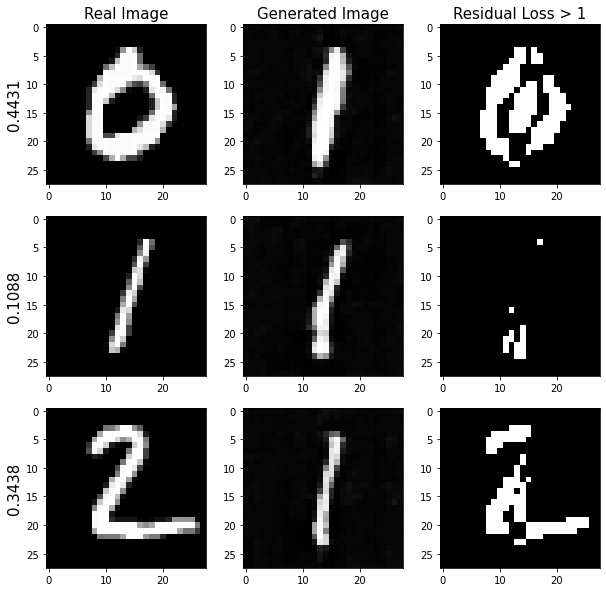

In [17]:
# Visualize result
fig, axes = plt.subplots(3, 3, figsize=(10,10))

for i, ax in enumerate(axes):
    ax[0].imshow(x_test[i].detach().to('cpu').reshape((28,28)), cmap='gray')
    ax[0].set_ylabel(round(result[i][1].item(), 4), size=15)
    if(i==0):
        ax[0].set_title("Real Image", size=15)
    
    ax[1].imshow(result[i][0].detach().to('cpu').reshape((28,28)), cmap='gray')
    if(i==0):
        ax[1].set_title("Generated Image", size=15)
    
    residual_loss = torch.abs(x_test[i] - result[i][0])
    ax[2].imshow((residual_loss>1).detach().to('cpu').reshape((28,28)), cmap='gray')
    if(i==0):
        ax[2].set_title("Residual Loss > 1", size=15)

plt.show()